# N-Body Simulations

Kit M. Gerodias

In [1]:
#[ Modules ]
import numpy as np
import matplotlib.pyplot as plt
import time
from IPython import display

In [119]:
#based from class

class Particles:
    #[ Initialize Particles and Fields ]
    def __init__(self, m=1.0, npart = 1000, soft = 0.03, G = 1.0, dt = 0.1, n_div = 128, cube_size = [-1,1], 
                 bc = "non-periodic", for_cosmo = 0):
        #set input parameters
        self.opts={}
        self.opts['soft'] = soft
        self.opts['n'] = npart
        self.opts['G'] = G
        self.opts['dt'] = dt
        self.opts['n_div'] = n_div
        self.opts['cube_size'] = cube_size
        self.opts['bc'] = bc
        #print(self.opts['cube_size'])
        #print(self.opts['soft'])
        #set particle location in (x,y,z)
        
        self.x = 2*np.random.rand(self.opts['n']) - 1 #2*rand(x) - 1 scaled for -1 to 1
        self.y = 2*np.random.rand(self.opts['n']) - 1
        self.z = 2*np.random.rand(self.opts['n']) - 1

        #print(self.x)
        #print(self.y)
        #print(self.z)
        
        self.m = np.ones(self.opts['n'])*m #set particle mass, equal for all particles
        
        #set velocities
        self.vx = 0*self.x
        self.vy = self.vx.copy()
        self.vz = self.vx.copy()
        
        if npart == 2:
            self.x = np.array([0.0, 0.01])
            self.y = np.array([0.0, 0.0])
            self.z = np.array([0.0, 0.0])
            
            self.vx = 0*self.x
            self.vy = np.array([50, -50]) #for a 0.01 radius
            self.vz = self.vx.copy()
            
        if for_cosmo == 1:
            self.cosmo_density()
        
        #set simulation box/cube dimensions
        self.grid_min = cube_size[0]
        self.grid_max = cube_size[1]
        self.n_div = self.opts['n_div']
        #print(self.opts['n_div'])
        #print(self.m)
        #print(self.vx)
        #print(self.vy)
        #print(self.vz)
        
        #set interval of equal length on the cube faces
        self.edges_x = np.linspace(self.grid_min, self.grid_max, self.n_div + 1)
        self.edges_y = np.linspace(self.grid_min, self.grid_max, self.n_div + 1)
        self.edges_z = np.linspace(self.grid_min, self.grid_max, self.n_div + 1)
        #centering grid points
        self.x_cgp = (self.edges_x[1:] - self.edges_x[:-1])*0.5 
        self.y_cgp = (self.edges_z[1:] - self.edges_y[:-1])*0.5
        self.z_cgp = (self.edges_z[1:] - self.edges_z[:-1])*0.5
        self.cell_size = self.edges_x[1] - self.edges_x[0] #can be y or z since they are all equal
        self.cell_size2 = self.x_cgp[1] - self.x_cgp[0]

        #print(self.cell_size)
        #print(self.cell_size2)
        #set particles and their respective location per cell
        #self.cell_part_density = np.zeros([ndiv, ndiv]) #2D test
        self.cell_part_density = np.zeros([self.n_div, self.n_div, self.n_div]) #particle per cell
        #print(self.cell_part_density)
        self.xpart_idx = np.digitize(self.x, self.edges_x)-1 # bin indexing of x coordinate;
        self.ypart_idx = np.digitize(self.y, self.edges_y)-1 # -1 is for compensation
        self.zpart_idx = np.digitize(self.z, self.edges_z)-1
        
        self.Fx = np.zeros([self.opts['n'], self.opts['n'], self.opts['n']])
        self.Fy = self.Fx.copy()
        self.Fz = self.Fx.copy()
        

    #[ Density field ]
    def get_density(self):
        #count particles per cell
        for i in range(len(self.xpart_idx)):
            #self.cell_part_density[self.xpart_idx[i], self.ypart_idx[i]] += 1 #2D test
            self.cell_part_density[self.xpart_idx[i], self.ypart_idx[i], self.zpart_idx[i]] += 1
        rho = self.cell_part_density/self.cell_size
        
        return rho
    
    #[ Green's function ]           
    def get_greens(self):
        #Green's function 
        xmat,ymat,zmat = np.meshgrid(self.x_cgp, self.y_cgp, self.z_cgp)            
        
        rsqr=xmat**2 + ymat**2 + zmat**2
        soft=self.opts['soft']**2
        rsqr[rsqr<soft]=soft
        rsqr=rsqr+self.opts['soft']**2
        r=np.sqrt(rsqr)
        dr=1.0/(r*rsqr)
        
        return 1/dr
    
    #[ Potential field ]
    def get_potential(self):
        
        rho = self.get_density()
        greens = self.get_greens()
        if self.bc == "non-periodic":
            rho_pad = np.pad(rho,[0,len(rho)],mode = 'constant')
            green_pad = np.pad(greens,[0,len(greens)],mode = 'constant')
            rho_fft = np.fft.fftn(rho_pad)
            green_fft = np.fft.fftn(green_pad)
            
            potential = np.real(np.fft.ifftn(rho_fft*green_fft))
            potential = np.fft.fftshift(potential)
            #potential = potential[:len(greens),:len(greens),:len(greens)]
        else:
            rho_fft = np.fft.fftn(rho)
            green_fft = np.fft.fftn(greens)
            
            potential = np.real(np.fft.ifftn(rho_fft*green_fft))
            potential = np.fft.fftshift(potential)
            
            
            
        return -potential
    
    #[ Forces ]
    def get_forces(self):

        F = np.gradient(self.get_potential())
        self.Fx = F[0]
        self.Fy = F[1]
        self.Fz = F[2]

        return self.Fx, self.Fy, self.Fz
    
    #[ Evolution ]
    def evolve(self, vx_half, vy_half, vz_half):
        #leapfrogging
        #bin
        #v one-half
        #should be initialized outside ...
        binn = np.column_stack((self.xpart_idx,self.ypart_idx,self.zpart_idx))
        #self.vx_half = self.Fx[binn[:,2],binn[:,1],binn[:,0]] * self.opts['dt']/2
        #self.vy_half = self.Fy[binn[:,2],binn[:,1],binn[:,0]] * self.opts['dt']/2
        #self.vz_half = self.Fz[binn[:,2],binn[:,1],binn[:,0]] * self.opts['dt']/2
        
        #update x,y,z positions
        self.x += vx_half *self.opts['dt']
        self.y += vy_half *self.opts['dt']
        self.z += vz_half *self.opts['dt']
        
        self.Fx, self.Fy, self.Fz = self.get_forces()
        
        vx_half += self.Fx[binn[:,2],binn[:,1],binn[:,0]] * self.opts['dt'] 
        vy_half += self.Fy[binn[:,2],binn[:,1],binn[:,0]] * self.opts['dt']
        vz_half += self.Fz[binn[:,2],binn[:,1],binn[:,0]] * self.opts['dt']
        
        potential = np.sum(self.get_potential())
        kinetic = 0.5 * np.sum(vx_half**2 + vy_half**2 + vz_half**2) * self.m

    
        return vx_half, vy_half, vz_half, potential, kinetic
    
        
    def cosmo_density(self):

        rho = self.get_density()
        rho_fft = np.fft.fftn(rho)
        k = np.abs(rho_fft)
        #add Gaussian noise
        rho_fft = rho_fft + np.random.randn(rho_fft.shape[0], rho_fft.shape[1], rho_fft.shape[2])*(k**(-3))
        rho = np.fft.fftshift(np.abs(np.fft.ifftn(rho_fft)))

        binn = np.column_stack((self.xpart_idx,self.ypart_idx,self.zpart_idx))

        self.m = rho[binn[:,2],binn[:,1],binn[:,0]] / self.cell_size

        return rho

        

        
    '''
    def get_forces(self):
        self.fx = np.zeros(self.opts['n'])
        self.fy = 0*self.fx
        self.fz = 0*self.fx
        potential = 0
        for i in range(0,self.opts['n']):
            dx = self.x[i] - self.x
            dy = self.y[i] - self.y
            dz = self.z[i] - self.z
            
            rsqr=dx**2 + dy**2 + dz**2
            
            soft = self.opts['soft']**2
            rsqr[rsqr<soft] = soft
            rsqr = rsqr+self.opts['soft']**2
            r = np.sqrt(rsqr)
            r3 = 1.0/(r*rsqr)
            self.fx[i] = -np.sum(self.m*dx*r3)*self.opts['G']
            self.fy[i] = -np.sum(self.m*dy*r3)*self.opts['G']
            self.fz[i] = -np.sum(self.m*dz*r3)*self.opts['G']
            
            potential += self.opts['G']*np.sum(self.m/r)*self.m[i]
            
        return -0.5*potential        

    def evolve(self):
        self.x += self.vx*self.opts['dt']
        self.y += self.vy*self.opts['dt']
        self.z += self.vz*self.opts['dt']
        
        potential = self.get_forces()
        
        self.vx += self.fx*self.opts['dt']
        self.vy += self.fy*self.opts['dt']
        self.vz += self.fz*self.opts['dt']
        
        kinetic = 0.5*np.sum(self.m*(self.vx**2+self.vy**2))

                
        return potential,kinetic
    '''
    

# Part 1

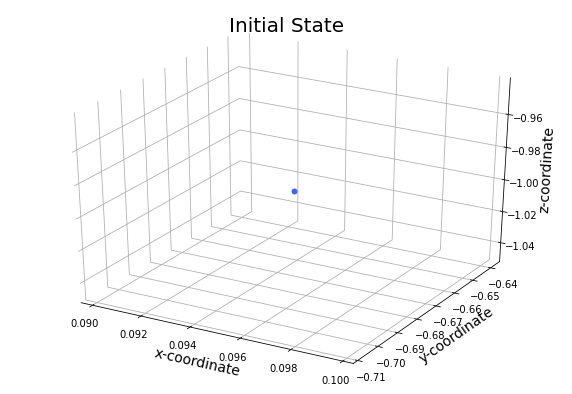

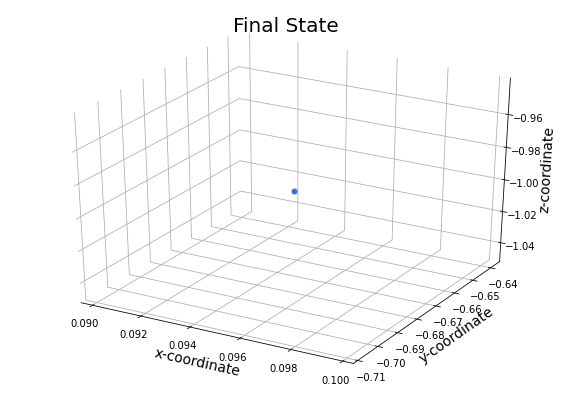

total time: 186.15712547302246


In [77]:
start = time.time()
n=1
oversamp=5
nstep = 10
part = Particles(m=1.0,npart=n,dt=0.1/oversamp)
initial_position = (part.x, part.y, part.z)

fig=plt.figure(figsize=(10,7))#Create 3D axes
try: ax=fig.add_subplot(111,projection="3d")
except : ax=Axes3D(fig) 
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

ax.scatter(part.x, part.y,part.z,color="royalblue",marker=".",s=100)
ax.set_xlabel("x-coordinate",fontsize=14)
ax.set_ylabel("y-coordinate",fontsize=14)
ax.set_zlabel("z-coordinate",fontsize=14)
ax.set_title("Initial State",fontsize=20)
plt.show()

part.get_forces()
#set leapfrog
binn = np.column_stack((part.xpart_idx,part.ypart_idx,part.zpart_idx))
vx_half = part.vx + part.Fx[binn[:,2],binn[:,1],binn[:,0]] * part.opts['dt']/2
vy_half = part.vy + part.Fy[binn[:,2],binn[:,1],binn[:,0]] * part.opts['dt']/2
vz_half = part.vz + part.Fz[binn[:,2],binn[:,1],binn[:,0]] * part.opts['dt']/2

for i in range(nstep):
    #plt.clf()
    for j in range(oversamp):
        
        vx_half, vy_half, vz_half, potential, kinetic = part.evolve(vx_half, vy_half, vz_half)
        #print(i,j, round(time.time() - start, 2))

final_position = (part.x, part.y, part.z)
fig=plt.figure(figsize=(10,7))#Create 3D axes
try: ax=fig.add_subplot(111,projection="3d")
except : ax=Axes3D(fig) 
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

ax.scatter(part.x, part.y,part.z,color="royalblue",marker=".",s=100)
ax.set_xlabel("x-coordinate",fontsize=14)
ax.set_ylabel("y-coordinate",fontsize=14)
ax.set_zlabel("z-coordinate",fontsize=14)
ax.set_title("Final State", fontsize=20)
plt.show()
print('total time:', time.time() - start)

In [78]:
final_position == initial_position

True

Motionless lonely particle

# Part 2

In [103]:
def plot(x, y, z, title, show = False, save = True, particles=0, image_no=0):
    fig=plt.figure(figsize=(10,7))#Create 3D axes
    try: ax=fig.add_subplot(111,projection="3d")
    except : ax=Axes3D(fig) 
    ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

    ax.scatter(x, y, z,color="royalblue",marker=".",s=100)
    ax.set_xlabel("x-coordinate",fontsize=14)
    ax.set_ylabel("y-coordinate",fontsize=14)
    ax.set_zlabel("z-coordinate",fontsize=14)
    ax.set_title(title,fontsize=20)
    if save == True:
        plt.savefig(str(particles)+"-particle"+str(image_no)+".png")
    plt.show()
    if show == True:
        display.clear_output(wait=True)

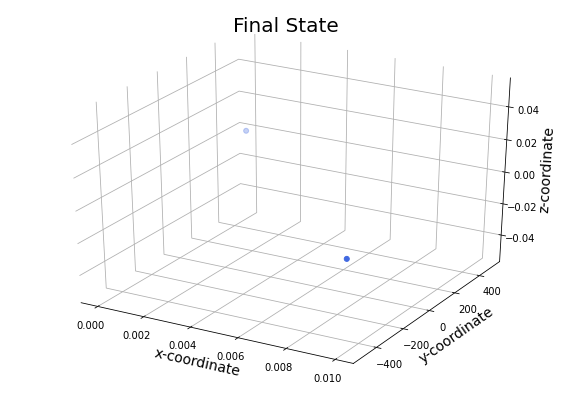

total time: 82.22994947433472


In [106]:
start = time.time()
n=2
oversamp=1
nstep = 100
part = Particles(m=1.0,npart=n,dt=0.1/oversamp)
initial_position = (part.x, part.y, part.z)
x_traj = np.zeros([nstep*oversamp, n])
y_traj = x_traj.copy()
z_traj = x_traj.copy()
x_traj[0] = part.x
y_traj[0] = part.y
z_traj[0] = part.z

plot(part.x, part.y, part.z, "Initial State", show = False)

#set leapfrog
part.get_forces()
binn = np.column_stack((part.xpart_idx,part.ypart_idx,part.zpart_idx))
vx_half = part.vx + part.Fx[binn[:,2],binn[:,1],binn[:,0]] * part.opts['dt']/2
vy_half = part.vy + part.Fy[binn[:,2],binn[:,1],binn[:,0]] * part.opts['dt']/2
vz_half = part.vz + part.Fz[binn[:,2],binn[:,1],binn[:,0]] * part.opts['dt']/2

for i in range(1,nstep*oversamp):
    #plt.clf()
    #for j in range(oversamp):
        
    vx_half, vy_half, vz_half, potential, kinetic = part.evolve(vx_half, vy_half, vz_half)
    #print(i,j, round(time.time() - start, 2))
    #trajectory
    x_traj[i] = part.x
    y_traj[i] = part.y
    z_traj[i] = part.z
    
    plot(part.x, part.y, part.z, None, show = True, particles=n, image_no=i)
    

plot(part.x, part.y, part.z, "Final State", show = False, particles=n, image_no=i)
print('total time:', time.time() - start)

I could not manage to make the two particles orbit each other. (Kindly see the clip) I should have tried to run this in two dimensions first before jumping the gun to three dimensions. Unfortunately, I ran out of time mainly because I spent it debugging. (I have no prior experience with classes so I challenged myself to learn it in this project. Unfortunately, it backfired as I expended way more time than I had anticipated in the bugs).

# Part 3

In [121]:
start = time.time()
n=100000
oversamp=1
nstep = 100
#bc is boundary conditions, it is non-periodic by default, if otherwise, the condition is periodic
part = Particles(m=1.0,npart=n,dt=0.1/oversamp, bc = "non-periodic")
initial_position = (part.x, part.y, part.z)
x_traj = np.zeros([nstep*oversamp, n])
y_traj = x_traj.copy()
z_traj = x_traj.copy()
x_traj[0] = part.x
y_traj[0] = part.y
z_traj[0] = part.z
potential_mat = np.zeros(nstep*oversamp-1)
kinetic_mat = potential_mat.copy()

plot(part.x, part.y, part.z, "Initial State", show = False)

#set leapfrog
part.get_forces()
binn = np.column_stack((part.xpart_idx,part.ypart_idx,part.zpart_idx))
vx_half = part.vx + part.Fx[binn[:,2],binn[:,1],binn[:,0]] * part.opts['dt']/2
vy_half = part.vy + part.Fy[binn[:,2],binn[:,1],binn[:,0]] * part.opts['dt']/2
vz_half = part.vz + part.Fz[binn[:,2],binn[:,1],binn[:,0]] * part.opts['dt']/2

for i in range(1,nstep*oversamp):
    #plt.clf()
    #for j in range(oversamp):
        
    vx_half, vy_half, vz_half, potential, kinetic = part.evolve(vx_half, vy_half, vz_half)
    #print(i,j, round(time.time() - start, 2))
    #trajectory
    x_traj[i] = part.x
    y_traj[i] = part.y
    z_traj[i] = part.z
    #energy tracking
    potential_mat[i] = potential
    kinetic_mat[i] = kinetic
    
    plot(part.x, part.y, part.z, None, show = True, particles=n, image_no=i)
    

plot(part.x, part.y, part.z, "Final State", show = False, particles=n, image_no=i)
print('total time:', time.time() - start)

MemoryError: 

In [26]:
np.zeros([50000, 50000])

MemoryError: 

As suggested by Marcus, I tried reducing the n_div but it did not work as well. Then when I tried 50,000 for only two dimensions, I already have a problem with memory... From the internet, there are suggestions how to deal with it like batch processing however I need to learn how to do them.  And I also ran out of ideas how to tackle this. 

In both part 3 and 4, I have incorporated the requirements of each part in the class Particles. (Please refer to the class above)

# Part 4

In [ ]:
start = time.time()
n=100000
oversamp=1
nstep = 100
#bc is boundary conditions, it is non-periodic by default, if otherwise, the condition is periodic
#for_cosmo = 0 by default, for 1/k^3, for_cosmo = 1
part = Particles(m=1.0,npart=n,dt=0.1/oversamp, for_cosmo = 1)
initial_position = (part.x, part.y, part.z)
x_traj = np.zeros([nstep*oversamp, n])
y_traj = x_traj.copy()
z_traj = x_traj.copy()
x_traj[0] = part.x
y_traj[0] = part.y
z_traj[0] = part.z
potential_mat = np.zeros(nstep*oversamp-1)
kinetic_mat = potential_mat.copy()

plot(part.x, part.y, part.z, "Initial State", show = False)

#set leapfrog
part.get_forces()
binn = np.column_stack((part.xpart_idx,part.ypart_idx,part.zpart_idx))
vx_half = part.vx + part.Fx[binn[:,2],binn[:,1],binn[:,0]] * part.opts['dt']/2
vy_half = part.vy + part.Fy[binn[:,2],binn[:,1],binn[:,0]] * part.opts['dt']/2
vz_half = part.vz + part.Fz[binn[:,2],binn[:,1],binn[:,0]] * part.opts['dt']/2

for i in range(1,nstep*oversamp):
    #plt.clf()
    #for j in range(oversamp):
        
    vx_half, vy_half, vz_half, potential, kinetic = part.evolve(vx_half, vy_half, vz_half)
    #print(i,j, round(time.time() - start, 2))
    #trajectory
    x_traj[i] = part.x
    y_traj[i] = part.y
    z_traj[i] = part.z
    #energy tracking
    potential_mat[i] = potential
    kinetic_mat[i] = kinetic
    
    plot(part.x, part.y, part.z, None, show = True, particles=n, image_no=i)
    

plot(part.x, part.y, part.z, "Final State", show = False, particles=n, image_no=i)
print('total time:', time.time() - start)

helpful sources:

Jon's codes especially nbody_animate.py

https://stackoverflow.com/questions/26783719/efficiently-get-indices-of-histogram-bins-in-python

https://mathworld.wolfram.com/GreensFunctionPoissonsEquation.html

https://realpython.com/python-scipy-fft/

https://astro.uchicago.edu/~andrey/talks/PM/pm.pdf

https://stackoverflow.com/questions/52470149/k-space-vector-for-n-body-simulation-box-dfts

# Tests

In [88]:
initial_position

(array([2.92728004e-16, 1.00000000e-02]),
 array([ 495., -495.]),
 array([-2.70647818e-17, -2.70647818e-17]))

In [91]:
final_position

(array([2.92728004e-16, 1.00000000e-02]),
 array([ 495., -495.]),
 array([-2.70647818e-17, -2.70647818e-17]))

In [97]:
len(x_traj)

100

In [38]:
rho = part.get_density()

In [39]:
len(rho)

128

In [110]:
np.fft.fftn(rho).shape

(128, 128, 128)

In [323]:
initial_position = (part.x, part.y, part.z)
final_position == initial_position

True

In [115]:
np.pad(rho,[0,len(rho)], mode = "constant").shape

(256, 256, 256)

In [67]:
ndiv = 128
part_cell_density = np.zeros([ndiv, ndiv, ndiv])
part_cell_density[:,1,:].shape

(128, 128)

Text(0.5, 0, 'z-coordinate')

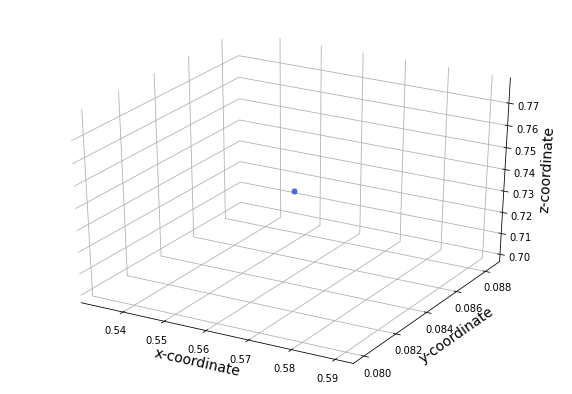

In [304]:
n=1
n_div = 128
part = Particles(m=1.0,npart=n,dt=0.1/oversamp)
rho = part.get_density()
#forces = part.get_forces()
fig=plt.figure(figsize=(10,7))#Create 3D axes
try: ax=fig.add_subplot(111,projection="3d")
except : ax=Axes3D(fig) 
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

ax.scatter(part.x, part.y,part.z,color="royalblue",marker=".",s=100)
ax.set_xlabel("x-coordinate",fontsize=14)
ax.set_ylabel("y-coordinate",fontsize=14)
ax.set_zlabel("z-coordinate",fontsize=14)

#ax.set_xlim3d(-1,1)
#ax.set_ylim3d(-1,1)
#ax.set_zlim3d(-1,1)


#ax.set_title("Initial conditions of the Universe\n",fontsize=20)
#ax.legend(loc="upper left",fontsize=14)
#ax.xaxis.set_ticklabels([])
#ax.yaxis.set_ticklabels([])
#ax.zaxis.set_ticklabels([])
#plt.savefig('3dinitial.png', dpi=1200)

In [251]:
part = Particles(m=1.0,npart=n,dt=0.1/oversamp)
rho = part.get_density()
potential = part.get_potential()
forces = part.get_forces()

[-0.63267154]
[-0.6214515]
[-0.89975204]


In [289]:
binn = np.column_stack((part.xpart_idx,part.ypart_idx,part.zpart_idx))
%time part.Fz[binn[:,2],binn[:,1],binn[:,0]]

Wall time: 13 ms


array([-1.57541584e-13])

In [288]:
np.where(part.Fz == part.Fz[binn[:,2],binn[:,1],binn[:,0]])

(array([6], dtype=int64), array([24], dtype=int64), array([23], dtype=int64))

In [278]:
np.column_stack((part.xpart_idx,part.ypart_idx,part.zpart_idx))

array([[23, 24,  6]], dtype=int64)

In [294]:
np.zeros([128, 128, 128]).shape

(128, 128, 128)

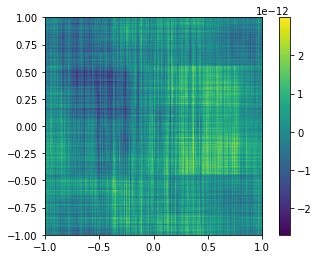

In [190]:
plt.imshow(part.get_potential()[0], extent=[-1,1,-1,1])
plt.colorbar()
plt.show()

In [117]:
rho[0].shape

(128, 128)

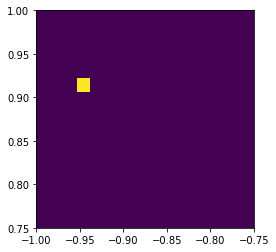

In [92]:
#2D test
n=1
ndiv = 128
part = Particles(m=1.0,npart=n,dt=0.1/oversamp)
rho = part.get_density()

plt.imshow(rho, extent=[-1,1,-1,1])
plt.xlim(-1,-0.75)
plt.ylim(0.75,1)
#plt.colorbar()
plt.show()

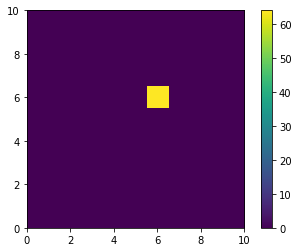

127
0.015748031496062964
0.0


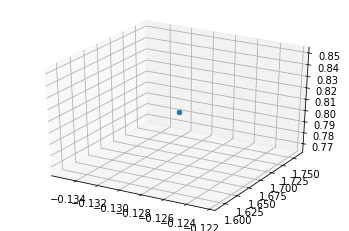

In [24]:
if __name__=='__main__':

    n=1
    oversamp=5
    
    part = Particles(m=1.0,npart=n,dt=0.1/oversamp)
    ax = plt.axes(projection='3d')
    ax.scatter3D(part.x,part.y,part.z,'*')
    plt.show()
    pot=0
    kin=0
    for i in range(100):
        #plt.clf()
        ax.scatter3D(part.x,part.y,part.z,'.')
        #display.clear_output(wait=True)
        plt.pause(0.1)
        plt.show()
        for j in range(oversamp):
            pot_old=pot
            kin_old=kin
            pot,kin=part.evolve()
        break
            
#print(pot+0.5*(kin+kin_old))

(11, 11, 11)
[-1.         -0.81818182 -0.63636364 -0.45454545 -0.27272727 -0.09090909
  0.09090909  0.27272727  0.45454545  0.63636364  0.81818182  1.        ]
[-1.         -0.81818182 -0.63636364 -0.45454545 -0.27272727 -0.09090909
  0.09090909  0.27272727  0.45454545  0.63636364  0.81818182  1.        ]
[-1.         -0.81818182 -0.63636364 -0.45454545 -0.27272727 -0.09090909
  0.09090909  0.27272727  0.45454545  0.63636364  0.81818182  1.        ]


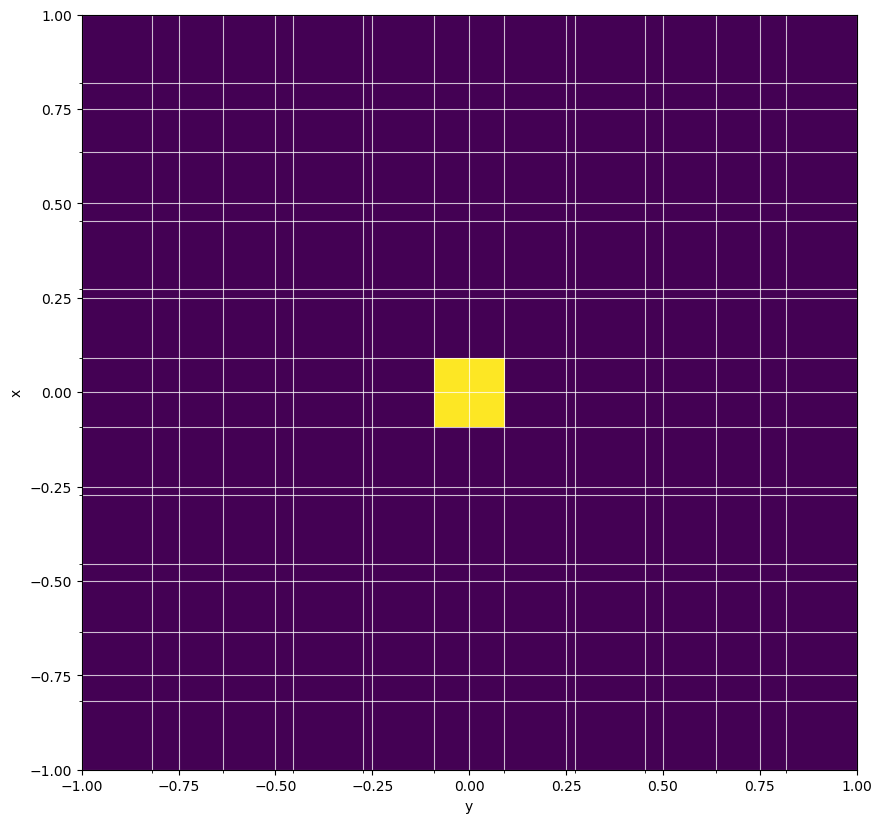

In [111]:
#from Marcus

x = np.array([0., 2.5])
y = np.array([0., -2.5])
z = np.array([0., 1.])
points = (x,y,z)

# Now we'll use histogramdd to make a three dimensional histogram of our points.
# Note that I'll specify the "box" we put our points in will span from -5 to 5 in each dimension
grid_min = -1.
grid_max = 1.
# Note I'll choose my number of grid points in each dimension to be 10, which is the distance
# between -5 and 5. This will ensure that each bin edge in my histogram is 1 "unit" apart.
n_grid = 11

# Now make the histogram ("H") and get bin edges for the cells
H, edges = np.histogramdd(
    points,
    bins=n_grid,
    range=((grid_min, grid_max), (grid_min, grid_max), (grid_min, grid_max)),
)
edges_x = edges[0]
edges_y = edges[1]
edges_z = edges[2]

print(H.shape)
print(edges_x)
print(edges_y)
print(edges_z)

# Now we'll plot a couple 2D histogram, summing over one dimension, to make sure things make sense
# Note I'll add a carefully made grid to show my exact bins. Also collapsing in into 2D for plotting
fig,ax = plt.subplots(figsize=(10,10), dpi=100)
ax.imshow(
    H.sum(axis=2),
    origin="lower",
    extent=(edges_y.min(), edges_y.max(), edges_x.min(), edges_x.max()), 
    aspect="auto"
)
# A bit backwards, but need to be careful of coordinate definitions when collapsing...
# When in doubt, just plot the histogram and double check the position of your points!
ax.set_xlabel("y")
ax.set_ylabel("x")
minor_ticks_x = edges_x
minor_ticks_y = edges_y
ax.set(xlim=(minor_ticks_y[0], minor_ticks_y[-1]), ylim=(minor_ticks_x[0], minor_ticks_x[-1]))
ax.set_xticks(minor_ticks_y, minor=True)
ax.set_yticks(minor_ticks_x, minor=True)

# Add a grid
ax.grid(which='both', alpha=0.75, color='w')
plt.show()

# NOTE: The point at (0,0,0) will appear to be in the bin between (0,0,0) and (1,1,1). This
# Is because the default behaviour for histogram is to "push" points that land on a bin edge
# to the right.